<a href="https://colab.research.google.com/github/ppijbb/Python_Notebook/blob/main/Financial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall pandas-datareader 
!pip install git+https://github.com/pydata/pandas-datareader.git

Uninstalling pandas-datareader-0.10.0.dev0+30.gadb67b2:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pandas_datareader-0.10.0.dev0+30.gadb67b2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pandas_datareader/*
Proceed (y/n)? y
  Successfully uninstalled pandas-datareader-0.10.0.dev0+30.gadb67b2
  Cloning https://github.com/pydata/pandas-datareader.git to /tmp/pip-req-build-mr__zoe0
  Running command git clone -q https://github.com/pydata/pandas-datareader.git /tmp/pip-req-build-mr__zoe0
  Created wheel for pandas-datareader: filename=pandas_datareader-0.10.0.dev0+30.gadb67b2-cp36-none-any.whl size=108709 sha256=9f461ae475d34c8e08136bc7bd25f9268877f442bda1869ba5028768e693e306
  Stored in directory: /tmp/pip-ephem-wheel-cache-zf0ri371/wheels/5f/4c/e3/f9e4e92cb4498744a91d53d37b840fb1959c286bf660740040
Successfully built pandas-datareader


In [ ]:
import requests
import json
from pandas import json_normalize
url = 'https://finance.naver.com/api/sise/etfItemList.nhn'
json_data = json.loads(requests.get(url).text)
df = json_normalize(json_data['result']['etfItemList'])

In [ ]:
import pandas as pd
financial_list = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
financial_list=financial_list.rename(columns={'회사명':'name','종목코드':'code'})

In [ ]:
search_by_name = input()
financial_list[financial_list['code'].isin([search_by_name])]

삼성화재


,name,code,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역


In [ ]:
import pandas as pd
import pandas_datareader as pdr
import datetime
# 종목 타입에 따라 download url이 다름. 종목코드 뒤에 .KS .KQ등이 입력되어야해서 Download Link 구분 필요
stock_type = {
'kospi': 'stockMkt',
'kosdaq': 'kosdaqMkt'
}
# 회사명으로 주식 종목 코드를 획득할 수 있도록 하는 함수
def get_code(df, name):
  code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
# 위와같이 code명을 가져오면 앞에 공백이 붙어있는 상황이 발생하여 앞뒤로 sript() 하여 공백 제거
  code = code.strip()
  return code
# download url 조합
def get_stock_code(market_type=None):
  market_type_param = stock_type[market_type]
  download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do'
  download_link = download_link + '?method=download'
  download_link = download_link + '&marketType=' + market_type_param
  df = pd.read_html(download_link, header=0)[0]
  return df;
# kospi 종목코드 목록 다운로드
def get_stock_code_kospi():
  df = get_stock_code('kospi')
  df.종목코드 = df.종목코드.map('{:06d}.KS'.format)
  return df
# kosdaq 종목코드 목록 다운로드
def get_stock_code_kosdaq():
  df = get_stock_code('kosdaq')
  df.종목코드 = df.종목코드.map('{:06d}.KQ'.format)
  return df
# Fast %K = ((현재가 - n기간 중 최저가) / (n기간 중 최고가 - n기간 중 최저가)) * 100
def get_stochastic_fast_k(close_price, low, high, n=5):
  fast_k = ((close_price - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
  return fast_k
# Slow %K = Fast %K의 m기간 이동평균(SMA)
def get_stochastic_slow_k(fast_k, n=3):
  slow_k = fast_k.rolling(n).mean()
  return slow_k
# Slow %D = Slow %K의 t기간 이동평균(SMA)
def get_stochastic_slow_d(slow_k, n=3):
  slow_d = slow_k.rolling(n).mean()
  return slow_d
# kospi, kosdaq 종목코드 각각 다운로드
kospi_df = get_stock_code_kospi()
kosdaq_df = get_stock_code_kosdaq()
# data frame merge
code_df = pd.concat([kospi_df, kosdaq_df])
# data frame정리
code_df = code_df[['회사명', '종목코드']]
# data frame title 변경 '회사명' = name, 종목코드 = 'code'
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})

In [ ]:
import pandas_datareader as pdr
code = get_code(code_df, '국일제지').split('.')[0]
start = datetime.datetime(2019,9,1)
end = datetime.date(2019,9,30)
# 수정주가를 반영
#df=pdr.naver.NaverDailyReader(code, start, end, adjust_price=True)

import pandas_datareader.data as web
df = web.DataReader(code, 'naver', start, end)

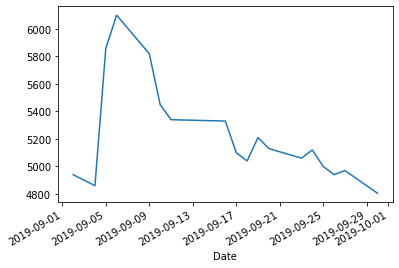

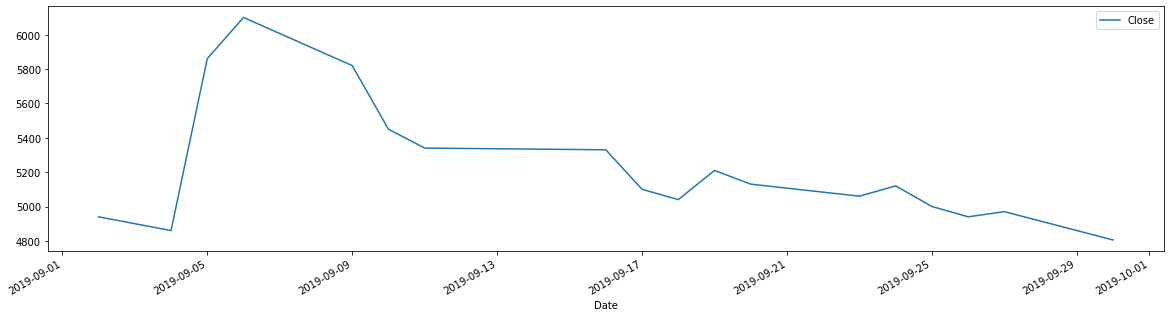

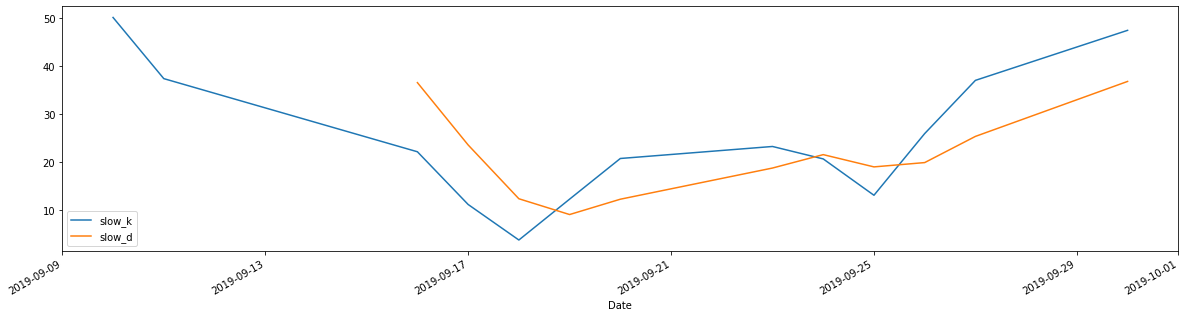

In [ ]:
df=df.astype(float)
df['Close'].plot()
# fast_k, slow_k, slow_d를 획득
df['fast_k'] = get_stochastic_fast_k(df['Close'], df['Low'], df['High'], 5)
df['slow_k'] = get_stochastic_slow_k(df['fast_k'], 3)
df['slow_d'] = get_stochastic_slow_d(df['slow_k'], 3)
df.plot(y=['Close'], figsize = (20, 5))
# Slow %K, Slow %D를 그려서 확인
df.plot(y=['slow_k', 'slow_d'], figsize = (20, 5))


In [ ]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup


URL = "https://finance.naver.com/item/main.nhn?code=005930"

samsung_electronic = requests.get(URL)
html = samsung_electronic.text

soup = BeautifulSoup(html, 'html.parser')

finance_html = soup.select('div.section.cop_analysis div.sub_section')[0]


In [ ]:
th_data = [item.get_text().strip() for item in finance_html.select('thead th')]
annual_date = th_data[3:7]
quarter_date = th_data[7:13]
finance_index = [item.get_text().strip() for item in finance_html.select('th.h_th2')][3:]
finance_data = [item.get_text().strip() for item in finance_html.select('td')]

In [ ]:
import numpy as np
finance_data = np.array(finance_data)
finance_data.resize(len(finance_index), 10)
finance_date = annual_date + quarter_date

In [ ]:
import pandas as pd
finance = pd.DataFrame(data=finance_data[0:,0:], index=finance_index, columns=finance_date)

In [ ]:
annual_finance = finance.iloc[:, :4]
quarter_finance = finance.iloc[:, 4:]

In [ ]:
annual_finance

,2017.12,2018.12,2019.12,2020.12(E)
매출액,"2,395,754","2,437,714","2,304,009","2,349,546"
영업이익,"536,450","588,867","277,685","333,045"
당기순이익,"421,867","443,449","217,389","252,913"
영업이익률,22.39,24.16,12.05,14.17
순이익률,17.61,18.19,9.44,10.76
ROE(지배주주),21.01,19.63,8.69,9.52
부채비율,40.68,36.97,34.12,
당좌비율,181.61,204.12,233.57,
유보율,"24,536.12","27,531.92","28,856.02",
EPS(원),"5,421","6,024","3,166","3,692"


In [ ]:
import pandas as pd
import requests
def ffinder(name):
  code = get_code(code_df, name).split('.')[0]
  URL_temp = "https://finance.naver.com/item/main.nhn?code=%s"
  URL = URL_temp % (code)
  df = requests.get(URL)
  html = df.text

  financial_stmt = pd.read_html(df.text)[3]

  financial_stmt.set_index(('주요재무정보', '주요재무정보', '주요재무정보'), inplace=True)
  financial_stmt.index.rename('주요재무정보', inplace=True)
  financial_stmt.columns = financial_stmt.columns.droplevel(2)
  return financial_stmt

In [ ]:
ffinder('초록뱀')

최근 연간 실적                  ... 최근 분기 실적                   
           2017.12 2018.12 2019.12  ...  2020.03 2020.06 2020.09(E)
주요재무정보                              ...                            
매출액            588     639     485  ...    45.00   69.00        NaN
영업이익             1      13      14  ...   -20.00  -10.00        NaN
당기순이익         -133    -154      89  ...     2.00  -58.00        NaN
영업이익률         0.17    2.01    2.89  ...   -43.35  -14.11        NaN
순이익률        -22.67  -24.04   18.35  ...     5.34  -84.88        NaN
ROE(지배주주)   -17.41  -17.90    8.35  ...    11.87   -1.35        NaN
부채비율         35.62   75.78   72.29  ...    73.51   98.15        NaN
당좌비율        152.96   87.01   40.25  ...    40.27   52.60        NaN
유보율         151.52  140.15  162.93  ...   165.41  151.55        NaN
EPS(원)        -213    -198      70  ...     2.00  -54.00        NaN
PER(배)       -6.26   -8.51   17.27  ...    10.91 -151.48        NaN
BPS(원)        1182     801     875  ...   890.00  845.00        NaN
PBR(배)        1.13    2.11    1.39  ...     1.21    1.96        NaN
주당배당금(원)       NaN       -       -  ...      NaN     NaN        NaN
시가배당률(%)       NaN       -       -  ...      NaN     NaN        NaN
배당성향(%)          -       -       -  ...      NaN     NaN        NaN

[16 rows x 10 columns]

In [ ]:
!pip install backtrader

     |████████████████████████████████| 419kB 2.6MB/s 


<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 4 Axes>]]

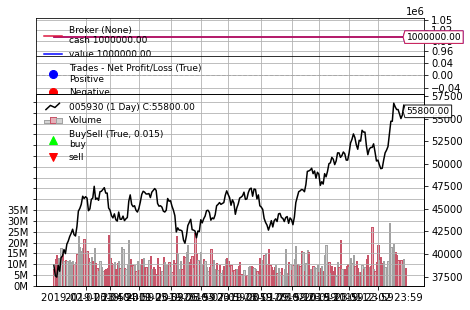

In [ ]:
from datetime import datetime
import backtrader as bt
class SmaCross(bt.Strategy): # bt.Strategy를 상속한 class로 생성해야 함.
  params = dict(
    pfast=5, # period for the fast moving average
    pslow=30 # period for the slow moving average
  )
def __init__(self):
  sma1 = bt.ind.SMA(period=self.p.pfast) # fast moving average
  sma2 = bt.ind.SMA(period=self.p.pslow) # slow moving average
  self.crossover = bt.ind.CrossOver(sma1, sma2) # crossover signal
def next(self):
  if not self.position: # not in the market
    if self.crossover > 0: # if fast crosses slow to the upside
      close = self.data.close[0] # 종가 값
      size = int(self.broker.getcash() / close) # 최대 구매 가능 개수
      self.buy(size=size) # 매수 size = 구매 개수 설정
  elif self.crossover < 0: # in the market & cross to the downside
    self.close() # 매도
cerebro = bt.Cerebro() # create a "Cerebro" engine instance
# 삼성전자의 '005930.KS' 코드를 적용하여 데이터 획득
data = bt.feeds.YahooFinanceData(dataname='005930.KS',
                                  fromdate=datetime(2019, 1, 1),
                                  todate=datetime(2019, 12, 31))
cerebro.adddata(data)
cerebro.broker.setcash(1000000) # 초기 자본 설정
cerebro.broker.setcommission(commission=0.00015) # 매매 수수료는 0.015% 설정
cerebro.addstrategy(SmaCross) # 자신만의 매매 전략 추가
cerebro.run() # 백테스팅 시작
cerebro.plot() # 그래프로 보여주기

In [ ]:
import requests
import pandas as pd
import re

n_client_id = 
n_client_pw = "FEQLRUPiw6"
search_word = '종목+저평가+코스피+대형주' #검색어
encode_type = 'json' #출력 방식 json 또는 xml
max_display = 10 #출력 뉴스 수
sort = 'date' #결과값의 정렬기준 시간순 date, 관련도 순 sim
start = 1 # 출력 위치

url = f"https://openapi.naver.com/v1/search/news.{encode_type}?query={search_word}&display={str(int(max_display))}&start={str(int(start))}&sort={sort}"

#헤더에 아이디와 키 정보 넣기
headers = {'X-Naver-Client-Id' : n_client_id,
           'X-Naver-Client-Secret':n_client_pw
           }

#HTTP요청 보내기
r = requests.get(url, headers=headers)
#요청 결과 보기 200 이면 정상적으로 요청 완료
print(r)

<Response [200]>


In [ ]:
r.json()
df =pd.DataFrame(r.json()['items'])
link =df['originallink']
def clean_html(x):
  x = re.sub("\&\w*\;","",x)
  x = re.sub("<.*?>","",x)
  return x

df['title'] = df['title'].apply(lambda x: clean_html(x))
df['description'] = df['description'].apply(lambda x: clean_html(x))

In [ ]:
df

,title,originallink,link,description,pubDate
0,대형주 강세 속 저평가된 ‘중소형주’ 랠리 도래한다,https://www.etoday.co.kr/news/view/1989632,https://www.etoday.co.kr/news/view/1989632,이투데이=오예린 기자 | 국내증시는 올해 대형주의 강세 속에서 코스닥과 코스피 중소...,"Thu, 28 Jan 2021 14:43:00 +0900"
1,"LG화학, 기아차, LG생건 등 호실적株 게걸음…쉬어갈까, 바로갈까, 떨어질까",http://www.bigtanews.co.kr/news/articleView.ht...,http://www.bigtanews.co.kr/news/articleView.ht...,코스피가 주춤하는 상황에서 이미 큰 폭의 주가 상승이 나타난 만큼 쉬어갈 것이라는 ...,"Thu, 28 Jan 2021 14:23:00 +0900"
2,"Rebuild Portfolio 코스피 3000시대 투자법, BBIG와 VVIG에 ...",http://news.mk.co.kr/newsRead.php?no=89319&yea...,https://news.naver.com/main/read.nhn?mode=LSD&...,▶반도체·그린뉴딜·2차전지 유망 이익개선된 대형주 투자유효 코스피 단기상승에 따른 ...,"Wed, 27 Jan 2021 16:44:00 +0900"
3,미지근한 대형주에 갈피 못 잡은 개미 일단 우선주로,https://biz.chosun.com/site/data/html_dir/2021...,https://news.naver.com/main/read.nhn?mode=LSD&...,26일 한국거래소와 금융투자업계에 따르면 코스피지수가 장중 3200을 넘고 상승세가...,"Wed, 27 Jan 2021 06:02:00 +0900"
4,코스피 대형주 쏠림·종목 한계…웃픈 ‘천스닥’,http://news.heraldcorp.com/view.php?ud=2021012...,https://news.naver.com/main/read.nhn?mode=LSD&...,코스피 대형주 쏠림 현상과 한정된 종목으로 인해 한계가 있다는 의견과 아직 저평가된...,"Tue, 26 Jan 2021 11:35:00 +0900"
5,['삼천피' 이어 '천스닥' 시대] 마냥 웃을수 없는 ‘천스닥’…코스피 대형주...,http://news.heraldcorp.com/view.php?ud=2021012...,https://news.naver.com/main/read.nhn?mode=LSD&...,코스피 대형주 쏠림 현상과 한정된 종목으로 인해 한계가 있다는 의견과 아직 저평가된...,"Tue, 26 Jan 2021 09:47:00 +0900"
6,대형주 초강세에 묻혔던 ‘중소형주’ 상승 준비 끝,http://news.kmib.co.kr/article/view.asp?arcid=...,https://news.naver.com/main/read.nhn?mode=LSD&...,같은 코스피 종목이라도 대형주(34.5%) 상승률이 소형주(18.4%)보다 월등히 ...,"Mon, 25 Jan 2021 04:08:00 +0900"
7,삼성·LG·현대 그룹주 펀드 평균 36~42% 수익,http://www.fntimes.com/html/view.php?ud=202101...,http://www.fntimes.com/html/view.php?ud=202101...,코스피 대형주인 LG화학은 2차전지 대표주로 분류돼 주목받고 있다. LG전자는 세계...,"Mon, 25 Jan 2021 00:03:00 +0900"
8,가뜩이나 소외받은 중소형주 '공매도 재개 찬물'…덜 불안한 종목 주목,https://view.asiae.co.kr/article/2021012208573...,https://news.naver.com/main/read.nhn?mode=LSD&...,수익률은 코스피와 대형주를 큰 폭으로 웃돌았기 때문에 저평가 구간에서 중소형주 반등...,"Fri, 22 Jan 2021 11:48:00 +0900"
9,"코스닥, 연기금 들어온다…중소형주 '노 젓자'",https://www.ebn.co.kr/news/view/1469031/?sc=Naver,https://www.ebn.co.kr/news/view/1469031/?sc=Naver,한대훈 SK증권 연구원은 국내를 대표하는 대형주는 최근 호재가 몰리며 증시상승을 견...,"Fri, 22 Jan 2021 11:06:00 +0900"


In [ ]:
from IPython.display import Javascript
def open_web(d):
    url = link[d]
    display(Javascript('window.open("{url}");'.format(url=url)))

In [ ]:
open_web(5)

<IPython.core.display.Javascript object>

In [ ]:
link

0           https://www.etoday.co.kr/news/view/1989632
1    http://www.bigtanews.co.kr/news/articleView.ht...
2    http://news.mk.co.kr/newsRead.php?no=89319&yea...
3    https://biz.chosun.com/site/data/html_dir/2021...
4    http://news.heraldcorp.com/view.php?ud=2021012...
5    http://news.heraldcorp.com/view.php?ud=2021012...
6    http://news.kmib.co.kr/article/view.asp?arcid=...
7    http://www.fntimes.com/html/view.php?ud=202101...
8    https://view.asiae.co.kr/article/2021012208573...
9    https://www.ebn.co.kr/news/view/1469031/?sc=Naver
Name: originallink, dtype: object

In [ ]:
!pip install dart-fss

     |████████████████████████████████| 71kB 3.0MB/s 
     |████████████████████████████████| 1.9MB 7.3MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for halo: filename=halo-0.0.31-cp36-none-any.whl size=11252 sha256=4951cef1a417255169080efd6e8e33ac183ed02f08038bd628d69041cba0e500
  Stored in directory: /root/.cache/pip/wheels/72/ca/3d/c8b682f6b166960e8880be54e92a0acd6f6279d26a138401ac
  Created wheel for arelle: filename=arelle-2.2-cp36-none-any.whl size=2060309 sha256=6b7d9290bfee9729ad20d67ffde1fe28188a59b5cbcfd87cebbfb0790bec51c9
  Stored in directory: /root/.cache/pip/wheels/85/28/41/d5cb57e0ad7bbc200950bdf3d09e5970063b910ca2f243ca93
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp36-none-any.whl size=13485 sha256=7167cd0eb2d4d6d5d8e51b3d5cff21d3447191c702041c313223e5137c87180f
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
Successfully built halo arelle fake-useragent


In [ ]:
import dart_fss as dart

api_key= # api key 변수 설정
dart.set_api_key(api_key=api_key) # 인증 설정
crp_list = dart.get_corp_list() # 상장회사 정보 리스트 받아오기
basic_info = crp_list.find_by_stock_code('005930') # 삼성전자 종목코드를 파라미터로 넣어 삼성전자 기본 정보 가져오기
financial_reports = basic_info.extract_fs(bgn_de='20190101') # 크롤링을 원하는 시작일자 설정
the_statements = financial_reports['bs'] # 크롤링한 데이터 중 재무상태표(fs : financial statements)만 선택하여 변수 할당

In [ ]:
the_statements

[D210000] Statement of financial position, current/non-current - Consolidated financial statements (Unit: KRW)  ...              20161231
                                                                                                       concept_id  ...             (연결재무제표,)
0                             ifrs-full_CurrentAssets                                                              ... 141,429,704,000,000.0
1                    ifrs-full_CashAndCashEquivalents                                                              ...  32,111,442,000,000.0
2   dart_ShortTermDepositsNotClassifiedAsCashEquiv...                                                              ...  52,432,411,000,000.0
3   entity00126380_udf_BS_2020210113420730_Current...                                                              ...   3,638,460,000,000.0
4   entity00126380_udf_BS_201851017339116_CurrentA...                                                              ...                   nan
5   ifrs-full_CurrentFinancialAssetsAtFairValueThr...                                                              ...                   nan
6                       dart_ShortTermTradeReceivable                                                              ...  24,279,211,000,000.0
7   entity00126380_udf_BS_201710182279121_CurrentA...                                                              ...   3,521,197,000,000.0
8   entity00126380_udf_BS_20171018221011173_Curren...                                                              ...   1,439,938,000,000.0
9   entity00126380_udf_BS_2017101822109437_Current...                                                              ...   3,502,083,000,000.0
10                              ifrs-full_Inventories                                                              ...  18,353,503,000,000.0
11                            dart_OtherCurrentAssets                                                              ...   1,315,653,000,000.0
12                         ifrs-full_NoncurrentAssets                                                              ... 120,744,620,000,000.0
13  entity00126380_udf_BS_2020210113513266_Noncurr...                                                              ...   6,804,276,000,000.0
14  entity00126380_udf_BS_2020210113515706_Noncurr...                                                              ...                   nan
15  entity00126380_udf_BS_20185101782898_Noncurren...                                                              ...                   nan
16  entity00126380_udf_BS_201851017830322_Noncurre...                                                              ...                   nan
17  entity00126380_udf_BS_201851017832579_Noncurre...                                                              ...                   nan
18  entity00126380_udf_BS_20171018221637438_Noncur...                                                              ...   5,837,884,000,000.0
19                ifrs-full_PropertyPlantAndEquipment                                                              ...  91,473,041,000,000.0
20        ifrs-full_IntangibleAssetsOtherThanGoodwill                                                              ...   5,344,020,000,000.0
21                 dart_DepositsForSeveranceInsurance                                                              ...     557,091,000,000.0
22                        ifrs-full_DeferredTaxAssets                                                              ...   5,321,450,000,000.0
23                         dart_OtherNonCurrentAssets                                                              ...   1,572,027,000,000.0
24                                   ifrs-full_Assets                                                              ... 262,174,324,000,000.0
25                       ifrs-full_CurrentLiabilities                                                              ...  54,704,095,000,000.0
26  entity00126380_udf_BS_20171018222617796_Curren...  

In [ ]:
import dart_fss as dart

# 삼성전자 code
corp_code = '005930'

# 모든 상장된 기업 리스트 불러오기
corp_list = dart.get_corp_list()

# 삼성전자
samsung = corp_list.find_by_stock_code(corp_code)

# 연간보고서 검색
reports = samsung.search_filings(bgn_de='20100101', pblntf_detail_ty='a001')
#reports = search_report(corp_code=corp_code, bgn_de='20100101', pblntf_detail_ty='a001')

# Reports의 Index는 0부터 시작
# 가장 최신 보고서 선택
newest_report = reports[0]

# 0-4번 보고서 선택
zero_to_fourth_report = reports[0:5]

# 짝수번째 보고서 선택
even_report = reports[::2]

# 가장 오래된 보고서 선택
oldest_report = reports[-1]

In [ ]:
newest_report.pages[10] # 최근 보고서 중 사업의 내용

{'dcm_no': '7202455',
 'dtd': 'dart3.xsd',
 'ele_id': '10',
 'length': '274286',
 'offset': '333495',
 'rcp_no': '20200330003851',
 'title': 'II.사업의내용'}